In [1]:
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
import dataframe_image as dfi
import dataframe_image as dfi
import matplotlib.pyplot as plt
import os
from random import randint
from statistics import mode, median
import json
import numpy as np
%matplotlib inline

In [2]:
# Our custom classifier scorer that looks at the frequency of specific kinds of misclassifications
def score_classifier(classifier, name, X_test, y_test): 
    pred = pd.Series(classifier.predict(X_test))
    truth = pd.Series(y_test)

    pred = list(pred)
    truth = list(truth)

    # Truth_Guess
    low_high = 0
    high_low = 0
    high_medium = 0



    for i in range(len(truth)):
        if truth[i] == 'low':
            if pred[i]== 'high':
                low_high = low_high + 1
        elif truth[i] == 'high':
            if pred[i]== 'low':
                high_low = high_low + 1
    
    spacer(name)
    print("Percent of people who were low risk but classified as high risk: ", str((low_high/len(pred))*100) + "%")
    print("Percent of people who were high risk but classified as low risk: ", str((high_low/len(pred))*100) + "%")
    print('Percent of Responsible Classifications:', 100-(((high_low)/len(pred))*100), "%")
    
    return (100-(((high_low)/len(pred))*100),  
            (low_high/len(pred))*100,
            (high_low/len(pred))*100)

def spacer(word):
    space = (30-len(word))//2
    
    if len(word)%2 != 0:
        print('-'*(space + 1) + word + '-'*space)
    else:
        print('-'*space + word + '-'*space)

In [3]:
# Load the data and print details
data = pd.read_csv('BigData/data_V10.csv')

# Remove country column
data.drop(['country'], axis=1, inplace=True)

print(data.shape)

(848118, 59)


In [4]:
# Split dataset into features and target
select = [x for x in data.columns if x != "severity_illness"]
X = data[select] 
y = data['severity_illness']

# 80 - 20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE oversampling for the minority class
sm = SMOTE(random_state = 2) 
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# nr = NearMiss() 
# X_train, y_train = nr.fit_sample(X_train, y_train.ravel()) 

# Store references to our models as well as their metrics
models =[]
model_names = ['XGBoost', 'Gaussian Naive-Bayes', 'Decision Tree', 'Random Forest', 'MLP Classifier']
test_accuracy = []
train_accuracy = []
low_high = []
high_low = []
auc_scores = []
responsible_classifications = []

In [5]:
# XGboost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

models.append(xgb)
train_accuracy.append(xgb.score(X_train, y_train))
test_accuracy.append(xgb.score(X_test, y_test))

In [6]:
# Gaussian Naive-Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

models.append(gnb)
train_accuracy.append(gnb.score(X_train, y_train))
test_accuracy.append(gnb.score(X_test, y_test))

In [7]:
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

models.append(tree)
train_accuracy.append(tree.score(X_train, y_train))
test_accuracy.append(tree.score(X_test, y_test))

In [8]:
# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

models.append(rfc)
train_accuracy.append(rfc.score(X_train, y_train))
test_accuracy.append(rfc.score(X_test, y_test))

In [9]:
# MLP classifier
clf = MLPClassifier()

clf.fit(X_train, y_train)

models.append(clf)
train_accuracy.append(clf.score(X_train, y_train))
test_accuracy.append(clf.score(X_test, y_test))

In [10]:
# Run custom metrics for each classifier
for i in range(len(models)):
    custom_metrics = score_classifier(models[i], model_names[i], X_test, y_test)
    
    responsible_classifications.append(custom_metrics[0])
    low_high.append(custom_metrics[1])
    high_low.append(custom_metrics[2])
    auc_scores.append(roc_auc_score(y_test, models[i].predict_proba(X_test)[:,1]))
    
    

------------XGBoost-----------
Percent of people who were low risk but classified as high risk:  12.60552751969061%
Percent of people who were high risk but classified as low risk:  1.70907418761496%
Percent of Responsible Classifications: 98.29092581238504 %
-----Gaussian Naive-Bayes-----
Percent of people who were low risk but classified as high risk:  0.0017686176484459748%
Percent of people who were high risk but classified as low risk:  5.196788190350422%
Percent of Responsible Classifications: 94.80321180964958 %
---------Decision Tree--------
Percent of people who were low risk but classified as high risk:  13.114299863226902%
Percent of people who were high risk but classified as low risk:  1.656015658161581%
Percent of Responsible Classifications: 98.34398434183842 %
---------Random Forest--------
Percent of people who were low risk but classified as high risk:  13.114299863226902%
Percent of people who were high risk but classified as low risk:  1.656015658161581%
Percent of 

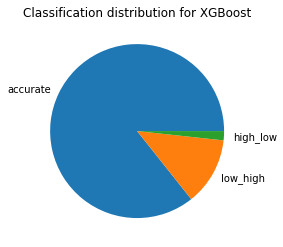

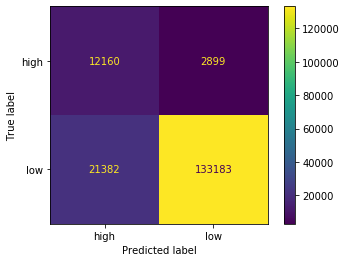

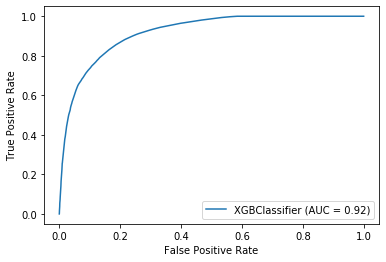

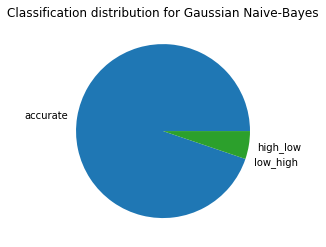

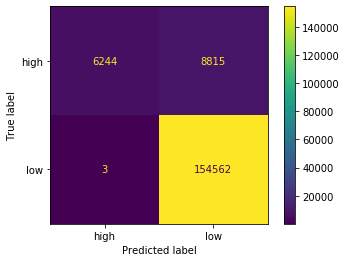

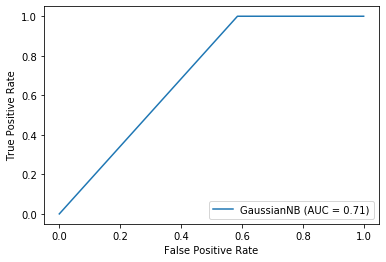

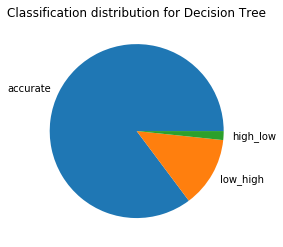

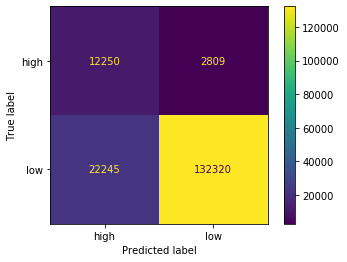

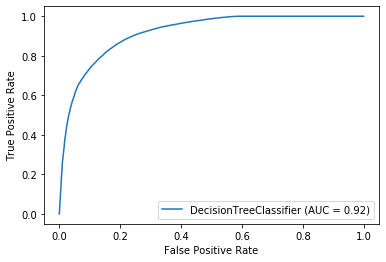

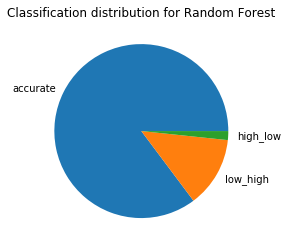

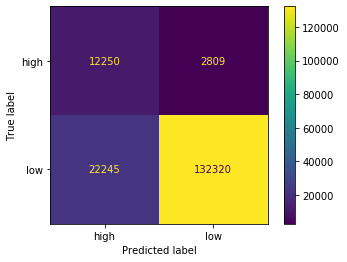

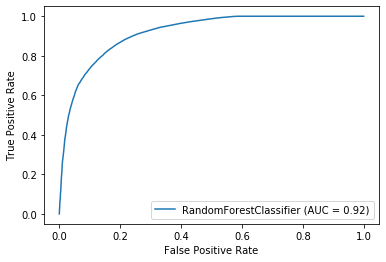

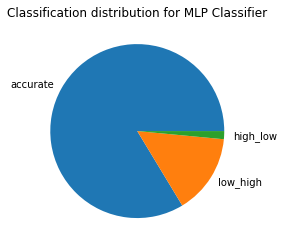

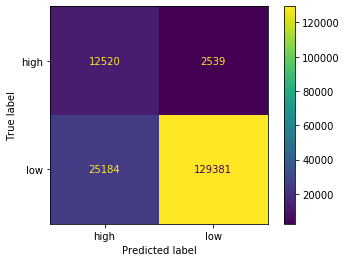

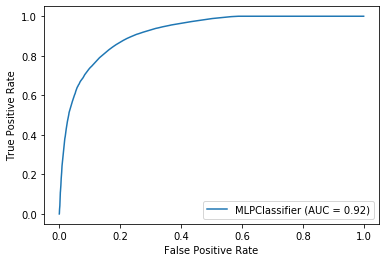

\begin{tabular}{llrrrrrr}
\toprule
{} &                 Model &  Test Accuracy &  Train Accuracy &  ROC\_AUC Scores &  \% of low\_high classifications &  \% of high\_low classifications &  \% of Responsible classifications \\
\midrule
0 &               XGBoost &       0.856854 &        0.834406 &        0.917678 &                      12.605528 &                       1.709074 &                         98.290926 \\
1 &  Gaussian Naive-Bayes &       0.948014 &        0.709896 &        0.707308 &                       0.001769 &                       5.196788 &                         94.803212 \\
2 &         Decision Tree &       0.852297 &        0.834566 &        0.917449 &                      13.114300 &                       1.656016 &                         98.343984 \\
3 &         Random Forest &       0.852297 &        0.834566 &        0.917503 &                      13.114300 &                       1.656016 &                         98.343984 \\
4 &        MLP Classifier &  

In [11]:
# Create classifier comparrision table
classifier_comparison = {
    "Model": model_names,
    "Test Accuracy": test_accuracy,
    "Train Accuracy": train_accuracy,
    "ROC_AUC Scores": auc_scores,
    "% of low_high classifications": low_high,
    "% of high_low classifications": high_low,
    "% of Responsible classifications": responsible_classifications,
}

# Plot classification distribution pie chart, confusion matrix, and roc curve for each classifier
for i in range(5):
    plt.pie([test_accuracy[i]*100, low_high[i], high_low[i]], labels=['accurate', 'low_high', 'high_low'])
    plt.title("Classification distribution for " + model_names[i])
    plt.xticks(rotation=90)
    plt.savefig("New_Figures/results/classification_distrb_" + model_names[i] + ".png")
    plt.show()
    
    plot_confusion_matrix(models[i], X_test, y_test)
    plt.savefig("New_Figures/results/confusion_matrix_" + model_names[i] + ".png")
    plt.show() 
    
    plot_roc_curve(models[i], X_test, y_test)
    plt.savefig("New_Figures/results/roc_curve_" + model_names[i] + ".png")
    plt.show() 



classifier_comparison = pd.DataFrame(classifier_comparison)

dfi.export(classifier_comparison.style.background_gradient(), "New_Figures/results/classifier_comparison_table.png")

print(classifier_comparison.to_latex())



In [12]:
# Extract feature importance information

feature_importance = rfc.feature_importances_

feature = []
importance = []
c_names = list(X.columns)

for f,i in enumerate(feature_importance):
    feature.append(c_names[f])
    importance.append(i)

sorter = pd.Series(data=importance,index=feature).sort_values(ascending=False)    
    
feature = sorter.index
importance = sorter.values
    
table = {
    'Feature': feature,
    'Importance': importance,
}

table = pd.DataFrame(table)

dfi.export(table.style.background_gradient(), "New_Figures/results/feature_importance_comparison_table.png", max_rows=-1)

print(table.to_latex())

table

\begin{tabular}{llr}
\toprule
{} &                                         Feature &    Importance \\
\midrule
0  &                                             age &  5.807732e-01 \\
1  &                    num\_of\_prexisting\_conditions &  1.982154e-01 \\
2  &                           disease(hypertension) &  8.780399e-02 \\
3  &                               disease(diabetes) &  6.335096e-02 \\
4  &                                disease(obesity) &  4.430528e-02 \\
5  &                         disease(kidney failure) &  7.211196e-03 \\
6  &                         disease(cardiovascular) &  6.383009e-03 \\
7  &          disease(chronic obstructive pulmonary) &  5.045447e-03 \\
8  &                      disease(immunosuppression) &  3.802198e-03 \\
9  &                                 disease(asthma) &  1.944880e-03 \\
10 &                                        sex\_male &  6.358994e-04 \\
11 &                                      sex\_female &  3.836664e-04 \\
12 &                

,Feature,Importance
0,age,5.807732e-01
1,num_of_prexisting_conditions,1.982154e-01
2,disease(hypertension),8.780399e-02
3,disease(diabetes),6.335096e-02
4,disease(obesity),4.430528e-02
5,disease(kidney failure),7.211196e-03
6,disease(cardiovascular),6.383009e-03
7,disease(chronic obstructive pulmonary),5.045447e-03
8,disease(immunosuppression),3.802198e-03
9,disease(asthma),1.944880e-03


In [13]:
classifier_comparison

,Model,Test Accuracy,Train Accuracy,ROC_AUC Scores,% of low_high classifications,% of high_low classifications,% of Responsible classifications
0,XGBoost,0.856854,0.834406,0.917678,12.605528,1.709074,98.290926
1,Gaussian Naive-Bayes,0.948014,0.709896,0.707308,0.001769,5.196788,94.803212
2,Decision Tree,0.852297,0.834566,0.917449,13.114300,1.656016,98.343984
3,Random Forest,0.852297,0.834566,0.917503,13.114300,1.656016,98.343984
4,MLP Classifier,0.836562,0.833762,0.917783,14.846956,1.496840,98.503160
